# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

### Overview

The notebook is broken into separate steps. 

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [19]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [20]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images. 

lfw/Bill_Clinton/Bill_Clinton_0022.jpg
('Number of faces detected:', 1)
(73, 69, 118, 118)


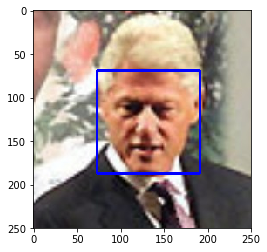

In [21]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
print(human_files[6])
img = cv2.imread(human_files[6])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    print(x,y,w,h)
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector


In [22]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [23]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

humanInHumans = np.sum([face_detector(i) for i in human_files_short])
humanInDogs = np.sum([face_detector(i) for i in dog_files_short])
print("%d of the first 100 images in human_files have a detected human face" % humanInHumans)
print("%d of the first 100 images in dog_files have a detected human face" % humanInDogs)

98 of the first 100 images in human_files have a detected human face
11 of the first 100 images in dog_files have a detected human face


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ I would say it is a faily reasonable expection imposed on the user because our Haar Cascades model is created using full frontal faces to detect full frontal faces, so it might not do well in detecting half faces.In order to detect humans in images with a partially presented face, we could train OpenCV on our object of interest (half faces in this case) with lots of images of half faces. Or we could use Google's OpenFace which is known to do quite well on side profiles.


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [24]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{number_images}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{number_images}, 224, 224, 3).
$$


In [25]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
#     print(x.shape)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    #print((np.expand_dims(x, axis=0)).shape)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.

In [26]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

In the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  

In [27]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [28]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
dogInHumans = np.sum([dog_detector(img) for img in human_files_short])
dogInDogs = np.sum([dog_detector(img) for img in dog_files_short])
print("%d of the images in human_files_short have a detected dog." % dogInHumans)
print("%d of the images in dog_files_short have a detected dog." % dogInDogs)

0 of the images in human_files_short have a detected dog.
100 of the images in dog_files_short have a detected dog.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [29]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255


100%|██████████| 6680/6680 [00:52<00:00, 126.33it/s]


In [30]:
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255


100%|██████████| 835/835 [00:05<00:00, 141.18it/s]


In [31]:
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:05<00:00, 142.78it/s]


### Model Architecture

           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step. 

__Answer:__ I think increasing the number of filters as we go might help the model train more efficiently. At the beginning, it might only be able to pick up the higher level features, and as time goes by, it would get better at connect these features together for a complete "big picture" of the image. MaxPooling is used after every Conv to reduce the amount of parameters, thus computation in the network. Afterwards, the output of the third pooling layer is flattened to 1D (via the Flatten layer), and passed through two fully connected (Dense) layers. ReLU activations are once again used for all layers except the output dense layer, which uses a softmax activation for classification.

In [32]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(32,(3, 3),activation='relu',input_shape=train_tensors[0].shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 53, 53, 128)       73856     
__________

### Compile the Model

In [33]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [34]:
from keras.callbacks import ModelCheckpoint  

epochs = 5
### save the model that attains the best validation
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 44s - loss: 4.9144 - acc: 0.0093 - val_loss: 4.8804 - val_acc: 0.0120
Epoch 2/5
6680/6680 [==============================] - 44s - loss: 4.8544 - acc: 0.0124 - val_loss: 4.7646 - val_acc: 0.0263
Epoch 3/5
6680/6680 [==============================] - 44s - loss: 4.7208 - acc: 0.0219 - val_loss: 4.6103 - val_acc: 0.0515
Epoch 4/5
6680/6680 [==============================] - 44s - loss: 4.5423 - acc: 0.0329 - val_loss: 4.4294 - val_acc: 0.0419
Epoch 5/5
6680/6680 [==============================] - 44s - loss: 4.4028 - acc: 0.0442 - val_loss: 4.3245 - val_acc: 0.0587


In [35]:
print(train_tensors.shape)

(6680, 224, 224, 3)


### Test the Model

In [36]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.0000%


---
<a id='step4'></a>
## Step 4: Transfer Learning: build a CNN to Classify Dog Breeds using VGG16 bottleneck features


### Obtain Bottleneck Features

In [37]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

print(train_VGG16.shape)
print(valid_VGG16.shape)
print(test_VGG16.shape)

(6680, 7, 7, 512)
(835, 7, 7, 512)
(836, 7, 7, 512)


### Model Architecture

In [38]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [39]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [40]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the Model with the Best Validation Loss
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')
print(train_targets.shape)
print(valid_targets.shape)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 1s - loss: 12.8200 - acc: 0.1043 - val_loss: 11.6180 - val_acc: 0.1665
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 10.9078 - acc: 0.2373 - val_loss: 10.6755 - val_acc: 0.2443
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 10.3324 - acc: 0.2981 - val_loss: 10.5225 - val_acc: 0.2743
Epoch 4/20
6680/6680 [==============================] - 1s - loss: 10.0394 - acc: 0.3293 - val_loss: 10.3006 - val_acc: 0.2946
Epoch 5/20
6680/6680 [==============================] - 1s - loss: 9.8897 - acc: 0.3561 - val_loss: 10.2865 - val_acc: 0.2922
Epoch 6/20
6680/6680 [==============================] - 1s - loss: 9.7305 - acc: 0.3647 - val_loss: 10.1203 - val_acc: 0.3066
Epoch 7/20
6680/6680 [==============================] - 1s - loss: 9.5880 - acc: 0.3793 - val_loss: 10.0534 - val_acc: 0.3078
Epoch 8/20
6680/6680 [==============================] - 1s - loss: 

### Test the Model


In [41]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 36.0000%


### Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model. The function has three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`.

In [42]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Transfer Learning: create a CNN to Classify Dog Breeds using the Xception Bottleneck Features

Choices are:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features


In [43]:
### Using bottleneck features from another pre-trained CNN called Xception.
bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

In [44]:
print(train_Xception.shape)
print(valid_Xception.shape)
print(test_Xception.shape)

(6680, 7, 7, 2048)
(835, 7, 7, 2048)
(836, 7, 7, 2048)


### Model Architecture
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ Honestly, I had a hard time picking which architecture to go with, because they are all well trained and produce amazing results. But in the end, I chose Xception because it came out more recently compared to the rest and was probably built with the other shortcomings in mind. Note that its default input size is 299x299, different from 
our training images of 224x224.

In [45]:
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model.add(Dense(133, activation='softmax'))

Xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### Train the Model

In [46]:
### compile the model
Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### train the model
checkpointer2 = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer2], verbose=1)

### load the model with the best Validation Loss
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s - loss: 1.0666 - acc: 0.7389 - val_loss: 0.5285 - val_acc: 0.8192
Epoch 2/20
6680/6680 [==============================] - 2s - loss: 0.3969 - acc: 0.8747 - val_loss: 0.4537 - val_acc: 0.8563
Epoch 3/20
6680/6680 [==============================] - 2s - loss: 0.3188 - acc: 0.9001 - val_loss: 0.4805 - val_acc: 0.8527
Epoch 4/20
6680/6680 [==============================] - 2s - loss: 0.2804 - acc: 0.9133 - val_loss: 0.4641 - val_acc: 0.8635
Epoch 5/20
6680/6680 [==============================] - 2s - loss: 0.2473 - acc: 0.9237 - val_loss: 0.4761 - val_acc: 0.8587
Epoch 6/20
6680/6680 [==============================] - 2s - loss: 0.2227 - acc: 0.9346 - val_loss: 0.4975 - val_acc: 0.8575
Epoch 7/20
6680/6680 [==============================] - 2s - loss: 0.1949 - acc: 0.9398 - val_loss: 0.5486 - val_acc: 0.8491
Epoch 8/20
6680/6680 [==============================] - 2s - loss: 0.1778 - ac

### Test the Model

In [53]:
# get index of predicted dog breed for each image in test set
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy_Xception = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy_Xception)

Test accuracy: 84.0000%


###  Predict Dog Breed with the Model

In [48]:
def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path));
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature);
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Putting it together

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def dog_breed_detector_Xception(img_path):
    img = mpimg.imread(img_path)
    _ = plt.imshow(img)
    if face_detector(img_path):
        plt.title("The human in the image most resembles a %s." % Xception_predict_breed(img_path));
    elif dog_detector(img_path): 
        plt.title ("This doggie is most likely a %s." % Xception_predict_breed(img_path));
    else:
        print("Please input an image of either a human or a dog!")
    plt.show()
    return

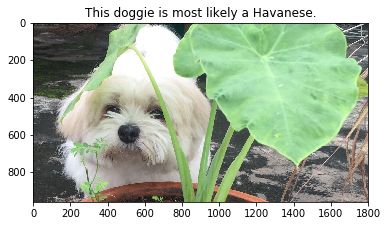

In [50]:
dog_breed_detector_Xception("images/ot1.jpg")

---
<a id='step7'></a>
## Step 7: How well does the Vanilla Algorithm work?

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The predictions are actually better than I expected. It got the color down, and in some cases a pretty close prediction (first image of my Maltese dog as a Bichon frise). In order to improve accuracy, I could increase the number of epochs, do some augmentation (flipping, rotation, etc.), decrease the learning rate, as well as increase the number of Conv layers.

In [51]:
def dog_breed_detector_from_scratch(img_path):
    img = mpimg.imread(img_path)
    _ = plt.imshow(img)
    if face_detector(img_path):
        tensor = path_to_tensor(img_path).astype('float32')/255
        index = np.argmax(model.predict(tensor))
        plt.title("The human in the image most resembles a %s." % dog_names[index]);
    elif dog_detector(img_path):
        tensor = path_to_tensor(img_path).astype('float32')/255
        index = np.argmax(model.predict(tensor))
        plt.title("This doggie is most likely a %s." % dog_names[index]);
    else:
        plt.title("Please input an image of either a human or a dog!")
    plt.show()
    return

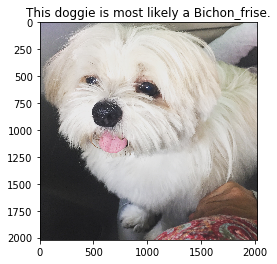

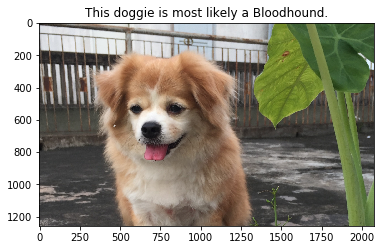

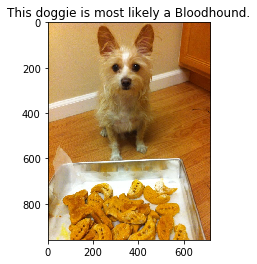

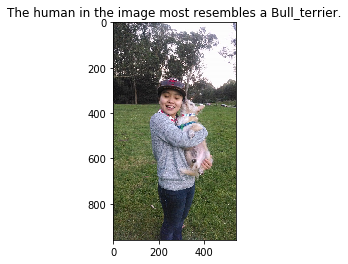

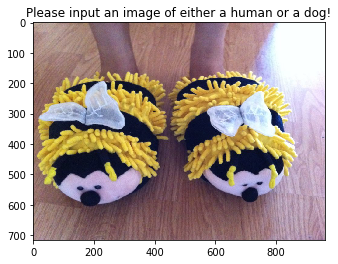

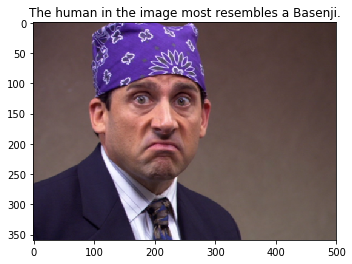

In [52]:
examples = ["images/myDog.jpg","images/myOtherDog.jpg", "images/myBaby.jpg","images/myself.jpg","images/1.jpg","images/MS.png"]
for i in range (0,6):
    dog_breed_detector_from_scratch(examples[i])